<a href="https://colab.research.google.com/github/SamoaChen/Frequentist-ML/blob/main/Gradient_Boosted_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost

In [ ]:
!wget https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data
!wget https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.data
import xgboost as xgb 
import sklearn, sklearn.datasets, sklearn.model_selection, sklearn.metrics, sklearn.inspection
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import ceil, floor, sqrt
from scipy.stats import mode
cal_housing = sklearn.datasets.fetch_california_housing()
heart_data = pd.read_csv("SAheart.data", sep=",", index_col=0).reset_index(drop=True)
heart_data['famhist'] = pd.get_dummies(heart_data['famhist'],drop_first=True)

RANDOM_STATE = 31415
LEARNING_RATE = 0.1
TREE_SIZE = 6
NUM_TREES = 800
LEGEND_COLOR = "white"

--2020-10-26 02:52:47--  https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7130 (7.0K)
Saving to: ‘prostate.data.1’

prostate.data.1     100%[===================>]   6.96K  --.-KB/s    in 0s      

2020-10-26 02:52:47 (231 MB/s) - ‘prostate.data.1’ saved [7130/7130]

--2020-10-26 02:52:47--  https://web.stanford.edu/~hastie/ElemStatLearn/datasets/SAheart.data
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25106 (25K)
Saving to: ‘SAheart.data.1’

SAheart.data.1      100%[===================>]  24.52K  --.-KB/s    in 0.03s   

2020-10-26 02:52:47 (926 KB/s) - ‘SAheart.data.1’ saved [25106/25106]



#XGBoosting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.inspection import plot_partial_dependence
from sklearn.ensemble import GradientBoostingRegressor

data = '/content/drive/My Drive/Colab Notebooks/ML_HW4/housing.csv'
housing = pd.read_csv(data, sep=',', header=0)
housing

,median_house_value,median_income,housing_median_age,total_rooms,total_bedrooms,population,households,latitude,longitude
0,452600,8.3252,41,880,129,322,126,37.88,-122.23
1,358500,8.3014,21,7099,1106,2401,1138,37.86,-122.22
2,352100,7.2574,52,1467,190,496,177,37.85,-122.24
3,341300,5.6431,52,1274,235,558,219,37.85,-122.25
4,342200,3.8462,52,1627,280,565,259,37.85,-122.25
...,...,...,...,...,...,...,...,...,...
20635,78100,1.5603,25,1665,374,845,330,39.48,-121.09
20636,77100,2.5568,18,697,150,356,114,39.49,-121.21
20637,92300,1.7000,17,2254,485,1007,433,39.43,-121.22
20638,84700,1.8672,18,1860,409,741,349,39.43,-121.32


In [ ]:
#-------------------SEPERATE TRAIN VALID AND TEST SETS
housing_train , housing_remain = train_test_split(housing, test_size=0.2, random_state=100, shuffle=True)
housing_valid , housing_test = train_test_split(housing_remain, test_size=0.5, random_state=100, shuffle=True)

#SEPERATE X AND Y VALUES
h_trainx = housing_train.drop(['median_house_value'], axis=1)
h_trainy = housing_train['median_house_value']

h_validx = housing_valid.drop(['median_house_value'], axis=1)
h_validy = housing_valid['median_house_value']

h_testx = housing_test.drop(['median_house_value'], axis=1)
h_testy = housing_test['median_house_value']

#STANDARDIZE DATA
h_trainx=(h_trainx-h_trainx.mean())/h_trainx.std(ddof=1)
h_validx=(h_validx-h_validx.mean())/h_validx.std(ddof=1)
h_testx=(h_testx-h_testx.mean())/h_testx.std(ddof=1)

In [ ]:
#---------------XGBoost TRAINING
params = {'n_estimators': 800, 'max_depth': 4, 'learning_rate': 0.1, 'loss': 'huber', 'random_state':42}
xgb_housing = GradientBoostingRegressor(**params)
xgb_housing.fit(h_trainx,h_trainy)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='huber',
                          max_depth=4, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=800,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Huber loss has regularization embeded already, so the L1, L2 coefficient are left blank, the max_depth is chose to be one unit larger than the conventional value, which improves the test set accuracy.

Text(0, 0.5, 'Deviance')

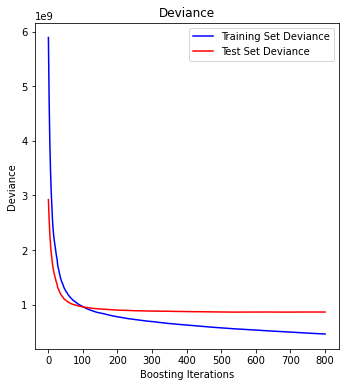

In [ ]:
#COMPUTE TEST SET DEVIANCE
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(xgb_housing.staged_predict(h_testx)):
    test_score[i] = xgb_housing.loss_(h_testy, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, xgb_housing.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

The training set error keeps decreasing when the iteration increases, but the error for testing set started to plateu after about 100 iteration. Both traing and testing has a relatively significant drop in error for the first 100 data set.

In [ ]:
#--------------COMPARE BASE CASE ERROR AND XGBOOST ERROR
abs_err_base = (np.abs(h_testy-h_testy.mean())).mean()
xgb_err = (np.abs(h_testy-xgb_housing.predict(h_testx))).mean()

print("The base case absolute error is : ", abs_err_base)
print("The absolute error calculated using gbr : ", xgb_err)


The base case absolute error is :  89721.48100183625
The absolute error calculated using gbr :  33701.149894567025


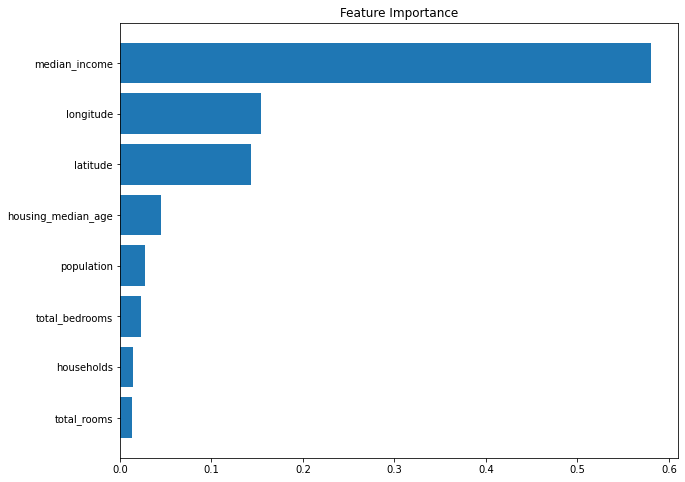

In [ ]:
#---------------PLOT RELATIVE IMPORTANCE
feature_names = h_trainx.columns
feature_importance = xgb_housing.feature_importances_
sorted_idx = feature_importance.argsort()
y_ticks = np.arange(0, h_trainx.shape[1])
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(y_ticks, feature_importance[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Feature Importance")
plt.show()

T feature with the most importance is median income, which matches with the resullt from the textbook and also with common sense, since icome of house hold represent their ability to purchase, so could represent their house price. The high importance of longitude and latitude are mostly because of the high real estate price at major cities.

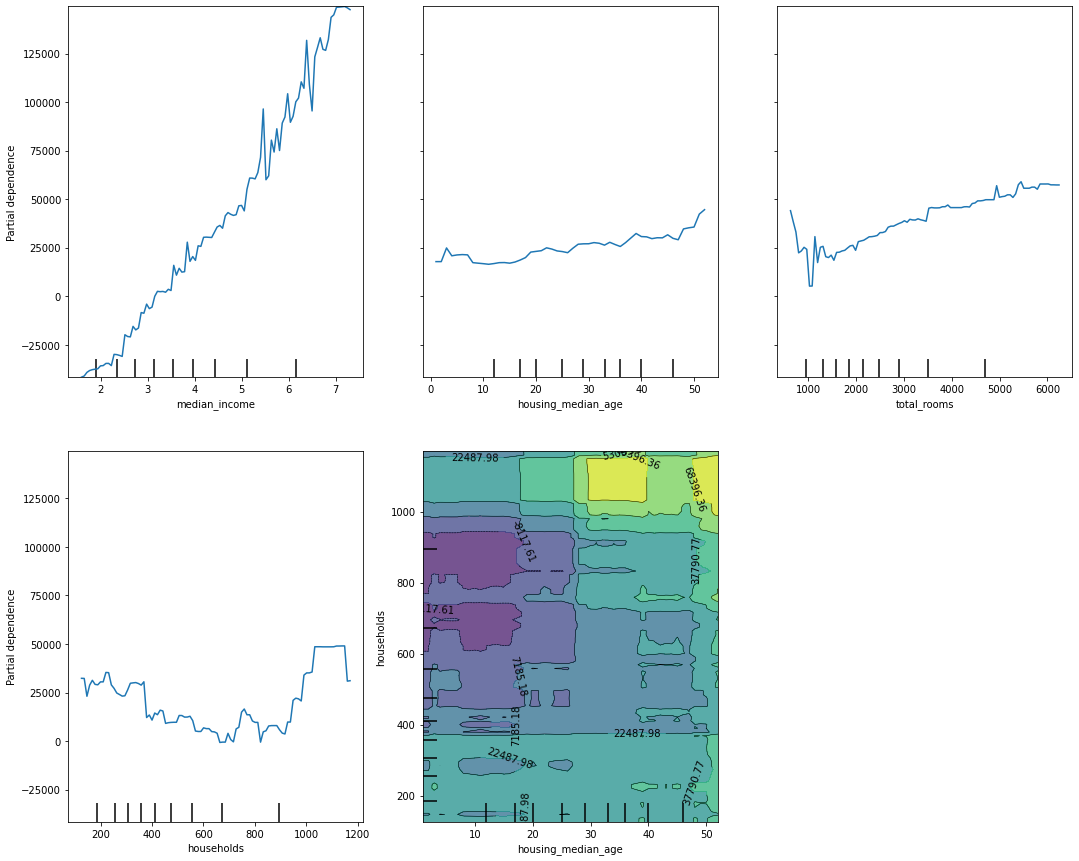

In [ ]:
#--------------PLOT PDP
fig, ax = plt.subplots(figsize=(18, 15))
features = [0, 1, 2, 5, (1, 5)]
plot_partial_dependence(xgb_housing,h_trainx,features,ax=ax)
plt.show()

(Note the those plots are plotted without standardizing the data, so they still have their original unit)As it is shown in the first median income partial dependence plot, the relationship is always linear between median income and house value,and data clustered at about the median value. The relatively flat curve of the partial dependence plot for housing age and rooms shows a less influence of them on the house value compare to median income. The plot for household number has a downward kink, at around 600, which could be caused by lack of data at that range.The same analysis can be applied to high household range.

#Repeating the Analysis on Extra Data Set

In [ ]:
#REPEAT THE ANALYSIS ON THE CANCER DATASET
data = '/content/drive/My Drive/Colab Notebooks/ML_HW4/cancer.txt'
prostate_data = pd.read_table(data,usecols=[1,2,3,4,5,6,7,8,9])


In [ ]:
#-------------------SEPERATE TRAIN VALID AND TEST SETS
cancer_train , cancer_remain = train_test_split(prostate_data, test_size=0.2, random_state=42, shuffle=True)
cancer_valid , cancer_test = train_test_split(cancer_remain, test_size=0.5, random_state=42, shuffle=True)

#SEPERATE X AND Y VALUES
c_trainx = cancer_train.drop(['lpsa'], axis=1)
c_trainy = cancer_train['lpsa']

c_validx = cancer_valid.drop(['lpsa'], axis=1)
c_validy = cancer_valid['lpsa']

c_testx = cancer_test.drop(['lpsa'], axis=1)
c_testy = cancer_test['lpsa']

#STANDARDIZE DATA
c_trainx=(c_trainx-c_trainx.mean())/c_trainx.std(ddof=1)
c_validx=(c_validx-c_validx.mean())/c_validx.std(ddof=1)
c_testx=(c_testx-c_testx.mean())/c_testx.std(ddof=1)

In [ ]:
#---------------XGBoost TRAINING
params_cancer = {'n_estimators': 1000, 'max_depth': 2, 'learning_rate': 0.01, 'loss': 'huber', 'random_state':42}
xgb_cancer = GradientBoostingRegressor(**params_cancer)
xgb_cancer.fit(c_trainx,c_trainy)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='huber',
                          max_depth=2, max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=1000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Because the relatively small sample size, the depth of tree is chosen to be 2 to avoid over fitting. And the learning rate is also set at a lower value at 0.01

Text(0, 0.5, 'Deviance')

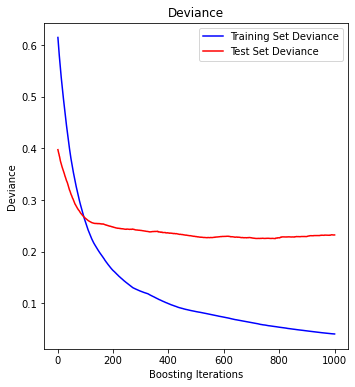

In [ ]:
#COMPUTE TEST SET DEVIANCE
test_score = np.zeros((params_cancer['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(xgb_cancer.staged_predict(c_testx)):
    test_score[i] = xgb_cancer.loss_(c_testy, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params_cancer['n_estimators']) + 1, xgb_cancer.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params_cancer['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

The deviance is rather large between test and training. An possible explanation is the sample size is too small. The test error also plateu after about 200 iterations.

In [ ]:
#--------------COMPARE BASE CASE ERROR AND XGBOOST ERROR
abs_err_base = (np.abs(c_testy-c_testy.mean())).mean()
xgb_err = (np.abs(c_testy-xgb_cancer.predict(c_testx))).mean()

print("The base case absolute error is : ", abs_err_base)
print("The absolute error calculated using gbr : ", xgb_err)


The base case absolute error is :  0.98940367
The absolute error calculated using gbr :  0.6724355949663968


In [ ]:
The xgboost method doesn't improve the accuracy of the prediction that much, which is highly likely due to the lacking of data

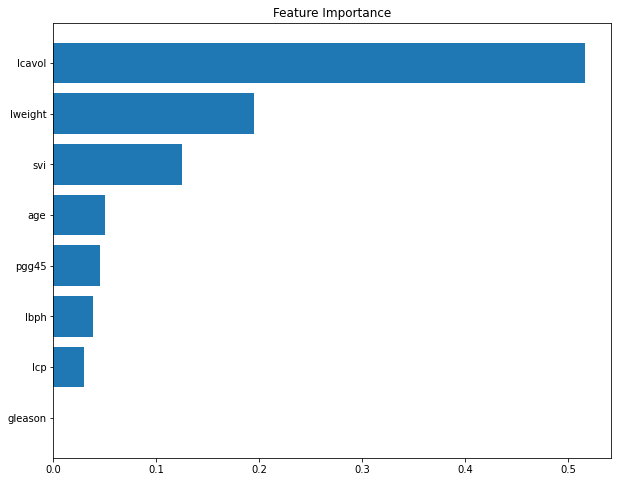

In [ ]:
#---------------PLOT RELATIVE IMPORTANCE
feature_names = c_trainx.columns
feature_importance = xgb_cancer.feature_importances_
sorted_idx = feature_importance.argsort()
y_ticks = np.arange(0, c_trainx.shape[1])
fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(y_ticks, feature_importance[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Feature Importance")
plt.show()

The most important feature predicted is lcavol, which matches with the result from HW1

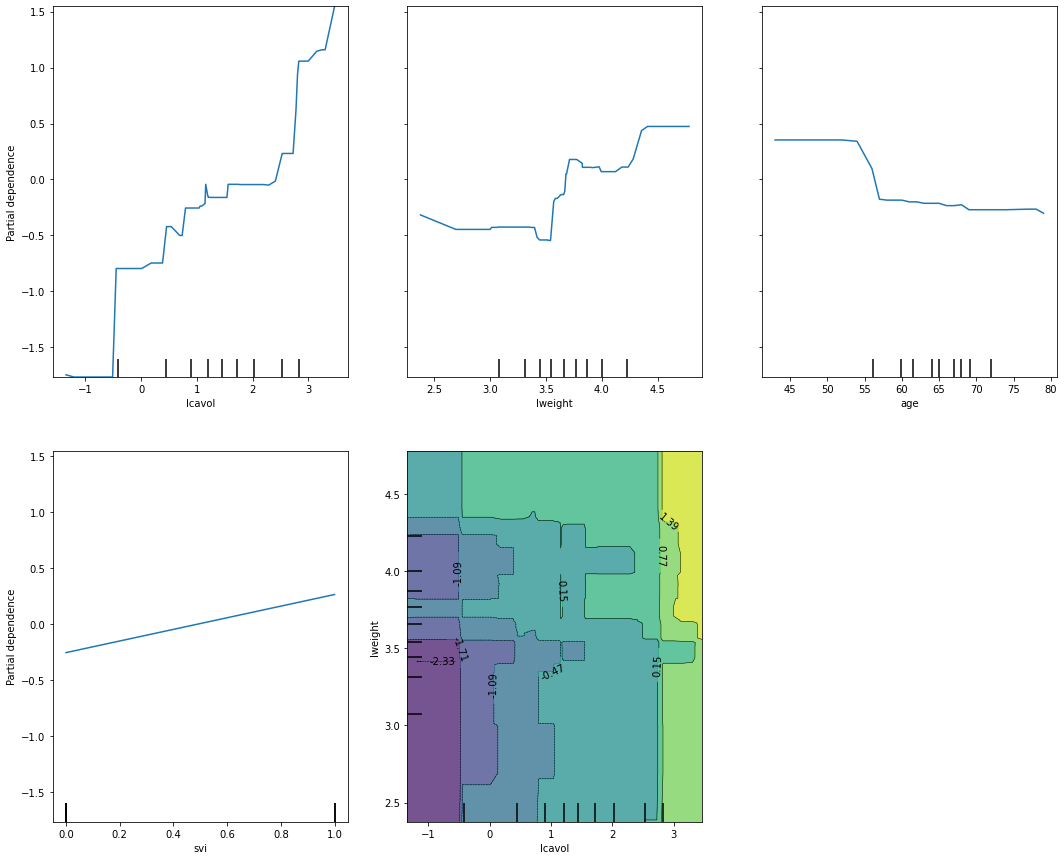

In [ ]:
#--------------PLOT PDP
fig, ax = plt.subplots(figsize=(18, 15))
features = [0, 1, 2, 4, (0, 1)]
plot_partial_dependence(xgb_cancer,c_trainx,features,ax=ax)
plt.show()

Those plots are rather not smooth, which is resulted from lacking data. From lcavol's plot, a possible linear relationship can be infered, as the lable value increase with increasing lcavol value. There seems to be a negative effect from age, but there is scarce data for age below 55. Other features shows a positive relationship with lpsa. The last pair PD plot matches with the results from features individual partial dependence plots.

#Extra question 1 Simple Tree Implementation

Stretch goal #1, 3 points: Implement a basic tree algorithm for both regression and classification. It must work for several loss functions: mean-squared error, misclassification, Gini index, and cross-entropy. You do not have to implement any pruning, but the # of nodes should be a parameter. Select a dataset to test your algorithm on, and tune it using cross-validation to select the optimal # of nodes. Compare against a baseline.

Stretch goal #2, 3 points: Use a simple tree method, (like your tree from stretch goal #1) and implement algorithm 10.3. Select a dataset, tune your algorithm and compare it against a baseline

In [ ]:
prostate_data = pd.read_csv("prostate.data", sep="\t", index_col=0).reset_index(drop=True).drop(labels=["train"], axis=1)

In [ ]:
# This tree is an adaptation of the tree described in https://machinelearningmastery.com/implement-decision-tree-algorithm-scratch-python/
# It is refactored into OOP code, augmented to support regression and additional scoring functions (cross entropy and misclassification error), and implements a print function for inspection

def prediction_mse(y_real, y_predict):
  error = y_real - y_predict
  error_squared = np.power(error, 2)
  return sum(error_squared)/len(error_squared)

def compute_baseline_accuracy(y, task):
  if task=="classification":
    # To determine the baseline accuracy for classification, just assume that all the values are whatever the majority value in the dataset is.
    baseline_accuracy = y.value_counts()[0]/len(y)
  elif task=="regression":
    # To determine the baseline accuracy for regression, just assume all values are the mean and get the MSE.
    baseline_accuracy = prediction_mse(y, y.mean())
  return baseline_accuracy

def gini_index(groups, unique_classes):
  num_samples = sum([len(group) for group in groups])
  gini = 0
  for group in groups:
    if len(group) == 0:
      continue
    else:
      proportions = [len(np.where(group[:, -1] == unique_class))/len(group) for unique_class in unique_classes]
      gini += sum(np.multiply(proportions, np.subtract(1, proportions)))*(len(group)/num_samples)
  return gini

def cross_entropy(groups, unique_classes):
  num_samples = sum([len(group) for group in groups])
  entropy = 0
  for group in groups:
    if len(group) == 0:
      continue
    else:
      proportions = [len(np.where(group[:, -1] == unique_class))/len(group) for unique_class in unique_classes]
      entropy -= sum(np.multiply(proportions, np.log(proportions)))*(len(group)/num_samples)
  return entropy

def misclassification_error(groups, unique_classes):
  num_samples = sum([len(group) for group in groups])
  error = 0
  for group in groups:
    if len(group) == 0:
      continue
    else:
      error += (1 - mode(group[:, -1])[0][0])*(len(group)/num_samples)

  return error

def terminal_mode(y):
  return mode(y)[0][0]

def mse(groups, unique_values):
  num_samples = sum([len(group) for group in groups])
  mse = 0
  for group in groups:
    if len(group) == 0:
      continue
    else:
      c = np.mean(group[:, -1])
      score = np.sum(np.square((group[:, -1] - c)))
      mse += score*len(group)/num_samples
  return mse

def score_accuracy(y_prediction, y_actual):
  assert len(y_prediction) == len(y_actual), "Length of prediction and actual arrays must be equal"
  if len(y_prediction.shape) > 1:
    return np.sum(np.all(y_prediction == y_actual, axis=1))/len(y_actual)
  else:
    return sum(y_prediction == y_actual)/len(y_actual)
  
class MyTree:
  def __init__(self, task="regression", scoring_func = None, max_depth = 5, min_size = 1):
    self.task = task
    self.max_depth = max_depth
    self.min_size = min_size
    if task=="regression":
      if not scoring_func:
        # use MSE as the default method for the greedy split algorithm
        self.scoring_func = mse
      else:
        self.scoring_func = scoring_func

      self.terminal_func = np.mean
      
    elif task=="classification":

      self.terminal_func = terminal_mode
      if not scoring_func:
        # use Gini index as the default method for the greedy split algorithm
        self.scoring_func = gini_index
      else:
        self.scoring_func = scoring_func

  def build(self, dataset, features=None):
    # If the dataset passed in is a DataFrame, convert the copy in this scope to a Numpy matrix so our syntax works.
    if type(dataset) != np.array:
      dataset = dataset.values
    unique_classes = np.unique(dataset[:, -1])
    self.root = Node(dataset, self.max_depth, self.min_size, 1, self.scoring_func, self.terminal_func,
                     features, unique_classes)
    self.root.expand()

  def predict(self, X):
    # Works with 1D rows and 2D matrix inputs.

    if type(X) != np.array:
      X = X.values
    n_dims = len(X.shape)
    if n_dims == 2:
      predictions = np.zeros((X.shape[0], 1))
      for i in range(X.shape[0]):
        predictions[i] = self.root.predict(X[i])

      return predictions
    elif n_dims == 1:
      return self.root.predict(X)

  def print(self):
    self.root.print()


class Node:
  def __init__(self, dataset, max_depth, min_size, node_depth, scoring_func, terminal_func,
               features, unique_classes,
               terminal_value = None):
    self.dataset = dataset
    self.max_depth = max_depth
    self.min_size = min_size
    self.node_depth = node_depth
    self.scoring_func = scoring_func
    # Terminal function is how we decide the output value once we know we're done splitting. We use mode for classification and mean for regression.
    self.terminal_func = terminal_func
    # Terminal value is the output value; assigning a terminal value means the node won't get split.
    self.terminal_value = terminal_value
    self.unique_classes = unique_classes
    self.children = []
    self.features = features
    if terminal_value is None:
      self.get_best_split()

  def expand(self):
    if not all(len(group) > 0 for group in self.groups):
      left_right_joined = np.concatenate(tuple([group[:, -1] for group in self.groups]))
      self.terminal_value = self.terminal_func(left_right_joined)
    elif self.node_depth >= self.max_depth:
      for group in self.groups:
        self.children.append(Node(group, self.max_depth, self.min_size, self.node_depth + 1,
                                  self.scoring_func, self.terminal_func, self.features, self.unique_classes,
                                  terminal_value = self.terminal_func(group[:, -1])))
    else:
      for group in self.groups:
        if len(group) <= self.min_size:
          self.children.append(Node(group, self.max_depth, self.min_size, self.node_depth + 1,
                                    self.scoring_func, self.terminal_func, self.features, self.unique_classes,
                                    terminal_value = self.terminal_func(group[:, -1])))
        else:
          node = Node(group, self.max_depth, self.min_size, self.node_depth + 1,
                                    self.scoring_func, self.terminal_func, self.features, self.unique_classes)
          self.children.append(node)
          node.expand()

  def get_best_split(self):
    y = self.dataset[-1, :]
    best_feature_index = None
    best_score = None
    best_split_value = None
    best_groups = None
    for column in range(self.dataset.shape[1] - 1):
      for row in self.dataset:
        groups = self.get_split(column, row[column])
        score = self.scoring_func(groups, self.unique_classes)
        if best_score is None:
          best_feature_index = column
          best_score = score
          best_split_value = row[column]
          best_groups = groups
        elif score < best_score:
          best_feature_index = column
          best_score = score
          best_split_value = row[column]
          best_groups = groups
    self.groups = best_groups
    self.feature_index = best_feature_index
    self.split_value = best_split_value
  
  def get_split(self, feature_index, split_value):
    left = self.dataset[np.where(self.dataset[:, feature_index] < split_value)]
    right = self.dataset[np.where(self.dataset[:, feature_index] >= split_value)]
    return left, right

  def predict(self, X):
    if self.terminal_value is not None:
      return self.terminal_value
    else:
      if X[self.feature_index] < self.split_value:
        return self.children[0].predict(X)
      else:
        return self.children[1].predict(X)

  def print(self):
    tabs = '\t' * self.node_depth
    if self.terminal_value is not None:
      print("{}return {:.4}".format(tabs, self.terminal_value))
    else:
      column = "row[{0}] ({1})".format(self.feature_index, self.features[self.feature_index]) if self.features is not None else "row[{}]".format(self.feature_index)
      print("{}if {} < {:.4}:".format(tabs, column, self.split_value))
      self.children[0].print()
      print("{}elif {} >= {:.4}:".format(tabs, column, self.split_value))
      self.children[1].print()

def tree_analysis(dataset, task="regression", max_depth = 5, min_size = 0):
  y = dataset.iloc[:, -1]
  if task=="regression":
    baseline_accuracy = compute_baseline_accuracy(y, task="regression")
    tree = MyTree(task=task, max_depth=max_depth, min_size=min_size)
    tree.build(dataset, dataset.columns.values[:-1])
    tree.print()
    predictions = tree.predict(dataset.iloc[:, :-1])
    print("The MSE of the regression is: {:.3}, against a baseline of {:.3}".format(prediction_mse(predictions.flatten(), dataset.iloc[:, -1]), baseline_accuracy))
  elif task=="classification":
    baseline_accuracy = compute_baseline_accuracy(y, task="classification")    
    for scoring_func, scoring_func_name in zip([gini_index, cross_entropy, misclassification_error], ["Gini index", "cross entropy", "misclassification error"]):
      tree = MyTree(task=task, scoring_func = scoring_func, max_depth=max_depth, min_size=min_size)
  
      tree.build(dataset, dataset.columns.values[:-1])
      tree.print()
      predictions = tree.predict(dataset.iloc[:, :-1])
      
      print("The accuracy of the model is {:.3}% correct for the {} loss function, against a baseline of {:.3}%".format(100*score_accuracy(predictions.flatten(), dataset.iloc[:, -1]), scoring_func_name, 100*baseline_accuracy))

In [ ]:
tree_analysis(prostate_data)

	if row[0] (lcavol) < 1.562:
		if row[0] (lcavol) < 0.4574:
			if row[0] (lcavol) < -0.4463:
				if row[1] (lweight) < 3.376:
					if row[2] (age) < 50.0:
						return 1.558
					elif row[2] (age) >= 50.0:
						return -0.03057
				elif row[1] (lweight) >= 3.376:
					if row[0] (lcavol) < -0.5447:
						return 1.157
					elif row[0] (lcavol) >= -0.5447:
						return 1.696
			elif row[0] (lcavol) >= -0.4463:
				if row[1] (lweight) < 4.09:
					if row[0] (lcavol) < 0.2231:
						return 1.827
					elif row[0] (lcavol) >= 0.2231:
						return 1.349
				elif row[1] (lweight) >= 4.09:
					if row[0] (lcavol) < 0.2852:
						return 2.963
					elif row[0] (lcavol) >= 0.2852:
						return 1.924
		elif row[0] (lcavol) >= 0.4574:
			if row[1] (lweight) < 3.568:
				if row[6] (gleason) < 7.0:
					if row[0] (lcavol) < 1.147:
						return 0.6638
					elif row[0] (lcavol) >= 1.147:
						return 1.715
				elif row[6] (gleason) >= 7.0:
					if row[3] (lbph) < 0.5596:
						return 1.979
					elif row[

In [ ]:
tree_analysis(heart_data, task="classification", max_depth=3)

	if row[0] (sbp) < 102.0:
		return 0.0
	elif row[0] (sbp) >= 102.0:
		if row[0] (sbp) < 103.0:
			return 1.0
		elif row[0] (sbp) >= 103.0:
			if row[0] (sbp) < 106.0:
				return 0.0
			elif row[0] (sbp) >= 106.0:
				return 0.0
The accuracy of the model is 65.6% correct for the Gini index loss function, against a baseline of 65.4%
	if row[0] (sbp) < 102.0:
		return 0.0
	elif row[0] (sbp) >= 102.0:
		if row[0] (sbp) < 103.0:
			return 1.0
		elif row[0] (sbp) >= 103.0:
			if row[0] (sbp) < 106.0:
				return 0.0
			elif row[0] (sbp) >= 106.0:
				return 0.0
The accuracy of the model is 65.6% correct for the cross entropy loss function, against a baseline of 65.4%
	if row[8] (age) < 47.0:
		if row[2] (ldl) < 6.33:
			if row[5] (typea) < 69.0:
				return 0.0
			elif row[5] (typea) >= 69.0:
				return 1.0
		elif row[2] (ldl) >= 6.33:
			return 1.0
	elif row[8] (age) >= 47.0:
		if row[0] (sbp) < 121.0:
			return 1.0
		elif row[0] (sbp) >= 121.0:
			return 1.0
The accuracy of the model is 66.2

In [ ]:
#------------CROSS VALIDATION FUNCTION

#SCORE FOR EACH TREE
def tree_accuracy_func(train_data, test_data, task, scoring_func, max_depth, min_size):
  if task == "classification":
    tree = MyTree(task="classification", scoring_func = scoring_func, max_depth = max_depth, min_size = min_size) 
    tree.build(train_data, train_data.columns.values[:-1])
    predictions = tree.predict(test_data.iloc[:, :-1])
    score = 100*score_accuracy(predictions.flatten(), test_data.iloc[:, -1])
    return score
  elif task == "regression":
    tree = MyTree(task="regression", max_depth=max_depth, min_size=min_size)
    tree.build(train_data, train_data.columns.values[:-1])
    predictions = tree.predict(test_data.iloc[:, :-1])
    score = prediction_mse(predictions.flatten(), test_data.iloc[:, -1])
    return score

#CROSS VALIDATION FUNCTION
def cross_vali(data, fold, task, scoring_func, max_depth, min_size):
  #STEP
  step = int(data.shape[0]/fold)
  #ERR VECTOR FOR CV 
  err_vec = np.zeros(fold)
  #LOOP THROUGH EACH FOLD
  for i in range(fold):
    test_cord = np.arange(i*step,i*step+step,1)
    train_cord = np.delete(np.arange(0,data.shape[0],1),test_cord)

    #CAL ERROR VECTOR
    err_vec[i] = tree_accuracy_func(data.iloc[train_cord,:], data.iloc[test_cord,:], task, scoring_func, max_depth, min_size)
  err = sum(err_vec)/err_vec.size

  return err

#FUNCTION FOR CALCULATING ERROR FOR EACH NODE
def node_err(data, task, depth, scoring_func):
  max_depth = depth
  err_depth_vec = np.zeros(max_depth)
  for num in np.arange(max_depth):
    err_depth_vec[num] = cross_vali(data = data, fold = 10, task = task, scoring_func= scoring_func, max_depth = (num+1), min_size = 0)
  return err_depth_vec

In [ ]:
#------------FINDING BEST DEPTH WITH CROSS VALIDATION
#REGRESSION
error = node_err(data = prostate_data, task = "regression", depth = 8, scoring_func = gini_index)
print("The scores for trees with depth from 1 to 8 ")
print(error)
#FIND BEST SMALLEST DEPTH
maxpos = np.where(error == error.min())
print("The best depth", maxpos[0]+1)

The scores for trees with depth from 1 to 8 
[1.07832166 1.02533636 1.08676228 1.09055129 1.14688762 1.26504383
 1.28241545 1.28450673]
The best depth [2]


In [ ]:
#CLASSIFICATION GINI INDEX
error = node_err(data = heart_data, task = "classification", depth = 8, scoring_func = gini_index)
print("The scores for trees with depth from 1 to 8 ")
print(error)
#FIND BEST SMALLEST DEPTH
maxpos = np.where(error == error.min())
print("The best depth ", maxpos[0]+1)

The scores for trees with depth from 1 to 8 
[65.2173913 65.        65.        65.        65.        65.
 65.2173913 65.2173913]
The best depth  [2 3 4 5 6]


In [ ]:
#CLASSIFICATION CROSS ENTROPY
error = node_err(data = heart_data, task = "classification", depth = 8, scoring_func = cross_entropy)
print("The scores for trees with depth from 1 to 8 ")
print(error)
#FIND BEST SMALLEST DEPTH
maxpos = np.where(error == error.min())
print("The best depth ", maxpos[0]+1)

The scores for trees with depth from 1 to 8 
[65.2173913 65.        65.        65.        65.        65.
 65.2173913 65.2173913]
The best depth  [2 3 4 5 6]


In [ ]:
#CLASSIFICATION MISCLASSIFICATION ERROR
error = node_err(data = heart_data, task = "classification", depth = 12, scoring_func = misclassification_error)
print("The scores for trees with depth from 1 to 12 ")
print(error)
#FIND BEST SMALLEST DEPTH
maxpos = np.where(error == error.min())
print("The best depth ", maxpos[0]+1)

The scores for trees with depth from 1 to 12 
[66.52173913 65.43478261 65.         64.13043478 63.91304348 63.69565217
 63.47826087 62.60869565 62.60869565 62.39130435 62.39130435 62.39130435]
The best depth  [10 11 12]


The score doesn't decrease after a depth of 10

#Extra quesiton2 Gradent Boosting Tree

In [ ]:
#------------IMPLEMENT GRADIENT BOOST WITH SIMPLE TREE
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

In [ ]:
#------------FUNCTIONS FOR GRADIENT BOOSTING TREE
#GRADIENT BOOSTING REGRESSOR USING MEAN SQURE ERROR
def gbr_mse(h_train_x, h_train_y, iteration, rate, tree_depth, leaf_num):
  reg_vec = []
  iteration_vec = np.arange(iteration)
  #COMPUTE THE FIRST RESIDULE
  residule =  h_trainy-h_train_y.mean()
  #FIRST PREDICTION
  pred = h_trainy
  pred.replace(h_trainy.to_numpy(),h_trainy.mean())
  #LOOP TO COMPUTE ALL ITERATIONS
  for num in iteration_vec:
    reg_new = DecisionTreeRegressor(criterion='mse',max_depth=tree_depth,max_leaf_nodes=leaf_num)
    reg_new.fit(h_trainx, residule)
    #APPEND EACH MODEL
    reg_vec.append(reg_new)
    #COMPUTE NEW RESIDULE
    pred = pred + rate*reg_vec[num].predict(h_trainx)
    residule = h_trainy - pred

  return reg_vec

#GBR USING MSE PREDICTION
def prediction_err(h_testx, h_testy, model, rate):
  #FIRST PREDICTION
  pred = h_testy
  pred.replace(h_testy.to_numpy(),h_testy.mean())
  #FIND PREDICTED VALUE USING MODEL
  for num in np.arange(len(model)):
    pred = pred+rate*model[num].predict(h_testx)
  
  #CALCULATE ERR
  err = (np.abs(h_testy-pred)).mean()

  return err



In [ ]:
#----------CALCULATING GRADIENT BOOSTING REGRESSOR USING MSE
iterations = 800
model = gbr_mse(h_trainx, h_trainy, iterations, 0.01, 3, 9)
#PREDICT FOR TEST SET

abs_err_base = (np.abs(h_testy-h_testy.mean())).mean()
abs_err_gbr = prediction_err(h_testx, h_testy, model, 0.01) 

print("The base case absolute error is : ", abs_err_base)
print("The absolute error calculated using gbr : ", abs_err_gbr)

The base case absolute error is :  89721.48100183625
The absolute error calculated using gbr :  0.19424218949191618


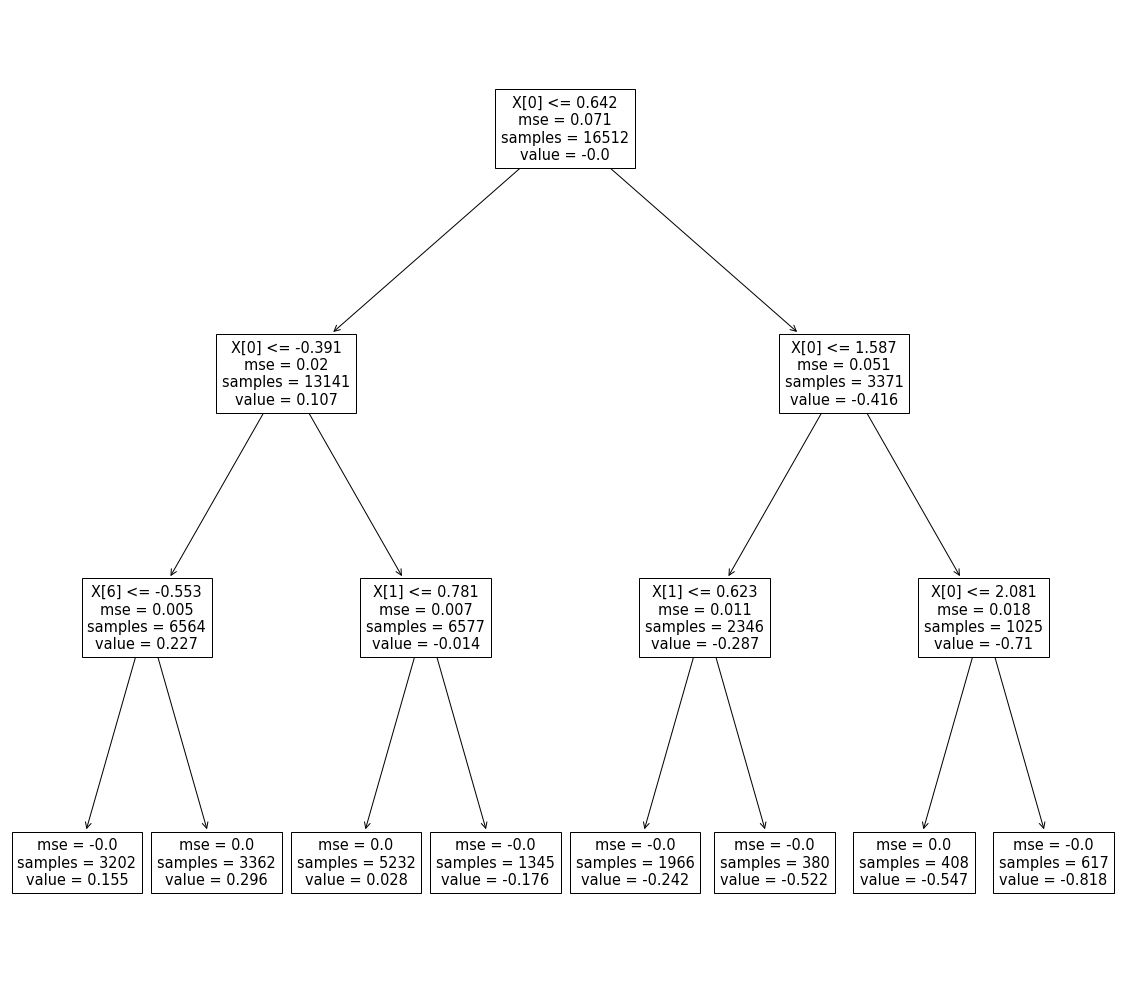

In [ ]:
#---------------PLOT TREE
fig1 = plt.figure(figsize = (20,18))
tree.plot_tree(model[799])
plt.show()

Because the calculation of absolute error for each iterations in test and train takes too long to computer, the plot is omited for this section